In [1]:
import warnings
from itertools import product
from functools import lru_cache, partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax.numpy as jnp
import sax
from jax import jit

from simphony.libraries import siepic

# SiEPIC models

In [3]:
wl = jnp.linspace(1.51, 1.59, 100)

## Grating coupler

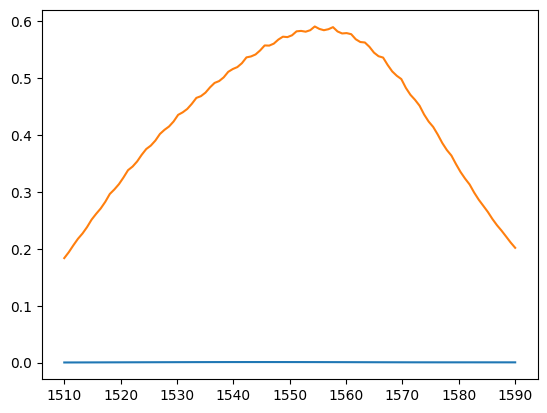

In [4]:
gc = siepic.grating_coupler(wl=wl)
plt.plot(1e3*wl, jnp.abs(gc['o0', 'o0'])**2, label="in0->out0")
plt.plot(1e3*wl, jnp.abs(gc['o0', 'o1'])**2, label="in0->out0")

In [5]:
def GC_fixed(wl=1.55):
    return siepic.grating_coupler(wl=wl, pol="te", thickness=220.0, dwidth=0)

## Y Branch

In [ ]:
y = siepic.y_branch(wl=wl)
plt.plot(1e3*wl, jnp.abs(y['o0', 'o0'])**2, label="in0->out0")
plt.plot(1e3*wl, jnp.abs(y['o0', 'o1'])**2, label="in0->out0")
plt.plot(1e3*wl, jnp.abs(y['o0', 'o2'])**2, label="in0->out0")

KeyError: ('o0', 'o1')

In [8]:
def Y_fixed(wl=1.55):
    return siepic.y_branch(wl=wl, pol="te", thickness=220.0, width=500)

## Waveguide

/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/models.py:974: UserWarning: Explicitly requested dtype <class 'numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ("o0", "o0"): jnp.zeros(wl_m.shape, dtype=np.complex128),
/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/models.py:977: UserWarning: Explicitly requested dtype <class 'numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ("o1", "o1"): jnp.zeros(wl_m.shape, dtype=np.complex128),


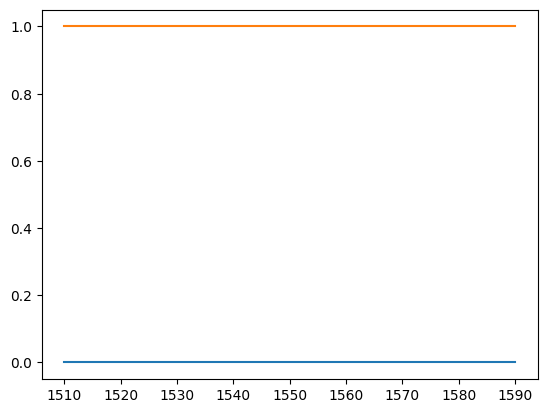

In [7]:
wg = siepic.waveguide(wl=wl)
plt.plot(1e3*wl, jnp.abs(wg['o0', 'o0'])**2, label="in0->out0")
plt.plot(1e3*wl, jnp.abs(wg['o0', 'o1'])**2, label="in0->out0")

In [8]:
def WG_fixed(wl=1.55, length=0):
    return siepic.waveguide(wl=wl, pol="te", length=length, width=500, height=220, loss=0)

# Comparison to Simphony

In [9]:
def wg_150(wl=1.55):
    return WG_fixed(wl=wl, length=150)

def wg_50(wl=1.55):
    return WG_fixed(wl=wl, length=50)

/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/models.py:974: UserWarning: Explicitly requested dtype <class 'numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ("o0", "o0"): jnp.zeros(wl_m.shape, dtype=np.complex128),
/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/models.py:977: UserWarning: Explicitly requested dtype <class 'numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ("o1", "o1"): jnp.zeros(wl_m.shape, dtype=np.complex128),
/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/

3.23 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.17 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


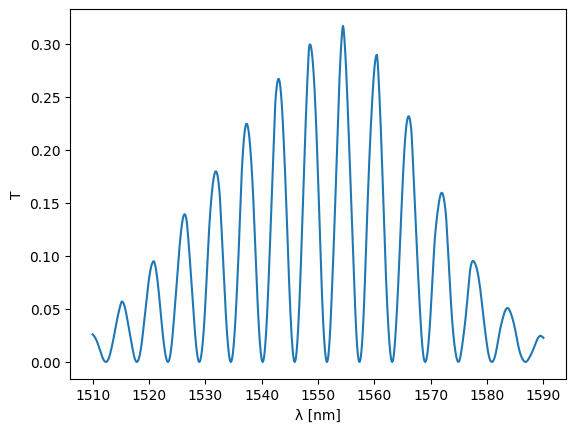

In [10]:
mzi, info = sax.circuit(
    netlist={
        "instances": {
            "ingc": "gc",
            "lft": "ybranch",
            "top": "wg_long",
            "btm": "wg_short",
            "rgt": "ybranch",
            "outgc": "gc",
        },
        "connections": {
            "ingc,o1": "lft,o0",
            "lft,o1": "btm,o0",
            "btm,o1": "rgt,o1",
            "lft,o2": "top,o0",
            "top,o1": "rgt,o2",
            "rgt,o0": "outgc,o1",
        },
        "ports": {
            "in": "ingc,o0",
            "out": "outgc,o0",
        },
    },
    models={
        "ybranch": Y_fixed,
        # "wg_long": lambda wl: WG_fixed(wl=wl, length=150),
        # "wg_short": lambda wl: WG_fixed(wl=wl, length=50),
        # "wg_long": wg_150,
        # "wg_short": wg_50,
        "wg_long": partial(siepic.waveguide, length=150),
        "wg_short": partial(siepic.waveguide, length=50),
        "gc": GC_fixed,
    }
)

wl = jnp.linspace(1.51, 1.59, 2000)

jitted_mzi = jit(mzi)
%timeit S = jitted_mzi(wl=wl)
%timeit S = jitted_mzi(wl=wl)
S = jitted_mzi(wl=wl)

plt.plot(wl * 1e3, abs(S["in", "out"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
# plt.ylim(-0.05, 1.05)
plt.show()

In [12]:
mzi, info = sax.circuit(
    netlist={
        "instances": {
            "ingc": "gc",
            "lft": "ybranch",
            "top": "waveguide",
            "btm": "waveguide",
            "rgt": "ybranch",
            "outgc": "gc",
        },
        "connections": {
            "ingc,o1": "lft,o0",
            "lft,o1": "btm,o0",
            "btm,o1": "rgt,o1",
            "lft,o2": "top,o0",
            "top,o1": "rgt,o2",
            "rgt,o0": "outgc,o1",
        },
        "ports": {
            "in": "ingc,o0",
            "out": "outgc,o0",
        },
    },
    models={
        "ybranch": siepic.y_branch,
        "waveguide": siepic.waveguide,
        "gc": siepic.grating_coupler,
    }
)

%timeit S = mzi(wl=wl, top={"length": 150.0}, btm={"length": 50.0})
S = mzi(wl=wl, top={"length": 150.0}, btm={"length": 50.0})

plt.plot(wl * 1e3, abs(S["in", "out"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
# plt.ylim(-0.05, 1.05)
plt.show()

RuntimeError: Instance lft does not contain port o0. Available ports: ['port_1', 'port_2', 'port_3'].

# Subcircuits in Sax

In [11]:
mzi_settings = {
    "top": {"length": 150.0},
    "btm": {"length": 50.0},
}

mzi_chain, info = sax.circuit(
    netlist={
        "instances": {
            "mzi1": mzi,
            "mzi2": mzi,
            "mzi3": mzi,
            # "mzi1": {
            #     "component": "mzi",
            #     "settings": mzi_settings,
            # },
            # "mzi2": {
            #     "component": "mzi",
            #     "settings": mzi_settings,
            # },
            # "mzi3": {
            #     "component": "mzi",
            #     "settings": mzi_settings,
            # },
        },
        "connections": {
            "mzi1,out": "mzi2,in",
            "mzi2,out": "mzi3,in",
        },
        "ports": {
            "in": "mzi1,in",
            "out": "mzi3,out",
        },
    },
    models={
        "mzi": partial(mzi, top={"length": 150.0}, btm={"length": 50.0}),
        # "mzi": mzi,
    }
)

version = 0
match version:
    case 0:
        S = mzi_chain(
            wl=wl, 
        )
    case 1:
        S = mzi_chain(
            wl=wl, 
            mzi1={"top": {"length": 150.0}, "btm": {"length": 50.0}}, 
            mzi2={"top": {"length": 150.0}, "btm": {"length": 50.0}}, 
            mzi3={"top": {"length": 150.0}, "btm": {"length": 50.0}}
        )
    case 2:
        S = mzi_chain(wl=wl)


plt.plot(wl * 1e3, abs(S["in", "out"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
# plt.ylim(-0.05, 1.05)
plt.show()

NameError: name 'mzi' is not defined

/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/models.py:974: UserWarning: Explicitly requested dtype <class 'numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ("o0", "o0"): jnp.zeros(wl_m.shape, dtype=np.complex128),
/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/models.py:977: UserWarning: Explicitly requested dtype <class 'numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ("o1", "o1"): jnp.zeros(wl_m.shape, dtype=np.complex128),
/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/

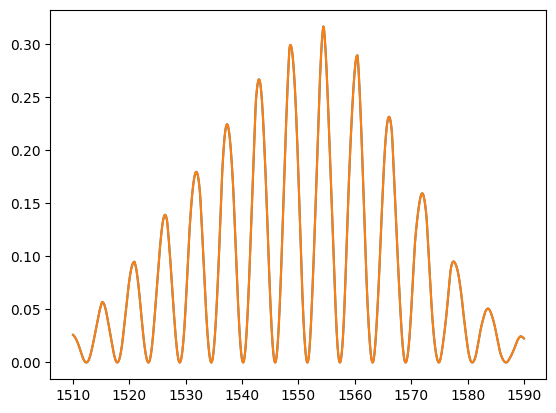

In [13]:
S = partial(mzi, top={"length": 150.0}, btm={"length": 50.0})(wl=wl)
plt.plot(wl * 1e3, abs(S["in", "out"]) ** 2)
S = mzi(wl=wl, top={"length": 150.0}, btm={"length": 50.0})
plt.plot(wl * 1e3, abs(S["in", "out"]) ** 2)

In [14]:
mzi?

Signature:
mzi(
    *,
    ingc={'wl': Array(1.55, dtype=float32), 'pol': 'te', 'thickness': Array(220., dtype=float32), 'dwidth': Array(0., dtype=float32)},
    lft={'wl': Array(1.55, dtype=float32), 'pol': 'te', 'thickness': Array(220., dtype=float32), 'width': Array(500., dtype=float32)},
    top={'wl': Array(1.55, dtype=float32), 'pol': 'te', 'length': Array(0., dtype=float32), 'width': Array(500., dtype=float32), 'height': Array(220., dtype=float32), 'loss': Array(0., dtype=float32)},
    btm={'wl': Array(1.55, dtype=float32), 'pol': 'te', 'length': Array(0., dtype=float32), 'width': Array(500., dtype=float32), 'height': Array(220., dtype=float32), 'loss': Array(0., dtype=float32)},
    rgt={'wl': Array(1.55, dtype=float32), 'pol': 'te', 'thickness': Array(220., dtype=float32), 'width': Array(500., dtype=float32)},
    outgc={'wl': Array(1.55, dtype=float32), 'pol': 'te', 'thickness': Array(220., dtype=float32), 'dwidth': Array(0., dtype=float32)},
) -> 'SType'
Docstring: <no docs

In [15]:
mzi_part = partial(mzi, top={"length": 150.0}, btm={"length": 50.0})
mzi_part?

Signature:     
mzi_part(
    *,
    ingc={'wl': Array(1.55, dtype=float32), 'pol': 'te', 'thickness': Array(220., dtype=float32), 'dwidth': Array(0., dtype=float32)},
    lft={'wl': Array(1.55, dtype=float32), 'pol': 'te', 'thickness': Array(220., dtype=float32), 'width': Array(500., dtype=float32)},
    top={'length': 150.0},
    btm={'length': 50.0},
    rgt={'wl': Array(1.55, dtype=float32), 'pol': 'te', 'thickness': Array(220., dtype=float32), 'width': Array(500., dtype=float32)},
    outgc={'wl': Array(1.55, dtype=float32), 'pol': 'te', 'thickness': Array(220., dtype=float32), 'dwidth': Array(0., dtype=float32)},
) -> 'SType'
Call signature: mzi_part(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function _flat_circuit.<locals>._circuit at 0x2afc8eb60>, top={'length': 150.0}, btm={'length': 50.0})
File:           /opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/functools.py
Docstring:     
partial(func, 

# Parameter sweeps/optimizations in Sax

In [16]:
# @jit
def somefunc(dl):
    S = mzi(wl=1.55, top={"length": 50.0+dl}, btm={"length": 50.0})
    return (abs(S["in", "out"]) ** 2).mean()

/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/models.py:974: UserWarning: Explicitly requested dtype <class 'numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ("o0", "o0"): jnp.zeros(wl_m.shape, dtype=np.complex128),
/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/models.py:977: UserWarning: Explicitly requested dtype <class 'numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ("o1", "o1"): jnp.zeros(wl_m.shape, dtype=np.complex128),
/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/

/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/models.py:974: UserWarning: Explicitly requested dtype <class 'numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ("o0", "o0"): jnp.zeros(wl_m.shape, dtype=np.complex128),
/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/models.py:977: UserWarning: Explicitly requested dtype <class 'numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ("o1", "o1"): jnp.zeros(wl_m.shape, dtype=np.complex128),
/Users/noah/Documents/CamachoLab/simphony/simphony/libraries/siepic/

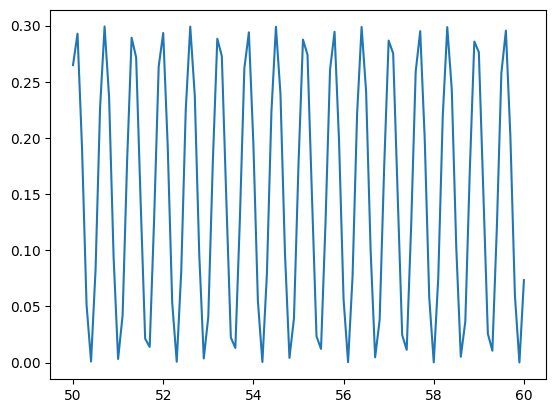

In [17]:
res = [(dl, somefunc(dl)) for dl in np.linspace(50,60,101)]
x, y = zip(*res)
plt.plot(x,y)